In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics as sk_m
# uncomment the following part if you run the code in Google Colab (recommended): 
#!pip install wget
#from google.colab import files
#files.upload() # upload the file tf_glove.py and utils_freq.py
import tf_glove
import utils_freq as utils

## Investigating the Influence of word Frequency on Word Embeddings

In their paper, [Wang et al. (2020)](https://arxiv.org/abs/2005.00965) proposed a short pilot study to investigate the influence that word frequency statistics have on the resulting embeddings and arguably also on the gender information contained. They trained GloVe [(Pennington et al. 2014)](https://nlp.stanford.edu/pubs/glove.pdf) embeddings on three augmentations of one dataset and compared the results.

### Download and augment Datasets

As Wang et al. (2020) proposed, we altered a dataset by changing the sampling frequency of selected gender specific words. Following the paper, we first created an augmented dataset for "boy", then one for "daughter" by sampling sentences containing these words twice. These corpora show a changed frequency statistic for the specific chosen words, while the sampling method ensures a consistent context for all words.

As 'baseline' data to train the GloVe model on, we have chosen a smaller text corpus, instead of the one billion English word benchmark ([Chelba et al., 2013](https://arxiv.org/abs/1312.3005)) used in the paper, to keep the training process feasible given our computational ressources. Even though we trained the embeddings on a different dataset, we could observe similar effects as the original authors.

The definitional pairs are downloaded from the [github repository of Wang et al. (2020)](https://github.com/uvavision/Double-Hard-Debias), just as in the main part of our replication.

In [3]:
# url of used text, could potentially be replaces
url_dataset = "http://mattmahoney.net/dc/text8.zip"

txt = utils.download_txt(url_dataset)

In [4]:
contains = [x in txt and y in txt for [x,y] in utils.definitional_pairs]
print("Check whether our text contains all the words of the definitional pairs:", all(contains))

Check whether our text contains all the words of the definitional pairs: True


In [5]:
sequence_length = 20 # GloVe paper shows best performance at context window 10
stride = 20 # sentences may not overlap
chosen_word_one = "boy"
chosen_word_two = "daughter"

print("number of consecutive words in corpus: ", len(txt))

data = utils.create_bag_of_words(txt, sequence_length, stride)
print("first three sentences:\nFirst: {0}\nSecond: {1}\nThird: {2}".format(data[0], data[1], data[2]))

# create datasets with altered frequencies
fake_boy = utils.fake_frequency(data, chosen_word_one)
fake_daughter = utils.fake_frequency(data, chosen_word_two)

number of consecutive words in corpus:  167285
first three sentences:
First: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']
Second: ['revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to']
Third: ['describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as']


### Train embeddings on GloVe

For the training process we used a tensorflow implementation of the GloVe model provided on [this github repository](https://github.com/GradySimon/tensorflow-glove). Due to time-constraints and the scale of the rest of our project, we were not able to fully implement it ourself, but adjusted some small bits to ensure that the provided (slightly outdated) code worked. Additionally, we changed the Optimizer from Adagrad to Adam, as that is the standard optimizer in todays' use. As this hugely impacts the training time (and this only serves as a pilot study), we only train the model on 10 Epochs, which is a rather low number.

This GloVe model is then used to create word embeddings both on the original data and the corpora with changed word frequency statistics for "boy" and for "daughter".

In [7]:
model = tf_glove.GloVeModel(embedding_size=300, context_size=10)
model.fit_to_corpus(data)
model.train(num_epochs=10)

In [8]:
# train GloVe embeddings on frequency-augmented data (for word "boy")
model_freq_b = tf_glove.GloVeModel(embedding_size=300, context_size=10)
model_freq_b.fit_to_corpus(fake_boy)
model_freq_b.train(num_epochs=10)

In [9]:
# train GloVe embeddings on frequency-augmented data (for word "daughter")
model_freq_d = tf_glove.GloVeModel(embedding_size=300, context_size=10)
model_freq_d.fit_to_corpus(fake_daughter)
model_freq_d.train(num_epochs=10)

## Investigate differences in Word Embeddings

### Cosine Similarities
Following the approach described by the authors, we first obtained the ten difference vectors of the gendered words in the definitional pairs, assuming that these approximate the gender direction in the embedding space.

Then, using these difference vectors, we compute cosine similarity matrices, in which entries represent the cosine similarities between the ten difference vectors. Ultimately, the change in those cosine similarities in relation to the non-augmented data are computed and depicted.

Even though our results are not as restricted to the specific definitional pair, we could observe significant changes in cosine similarities similarly to Wang et al. (2020). Differences can be explained due to the different datasets used, and also due to the variance of training GloVe in general.

Nevertheless, our results also indicate that changing the word frequency of one gender specific word significantly influences the gender direction that it captures in line with Wang et al. (2020).

In [10]:
def_pairs = []
def_pairs_freq_b = []
def_pairs_freq_d = []

# obtain the GloVe embeddings for the definitional pairs
for pair in utils.definitional_pairs:
    pair_emb = []
    pair_emb_freq_b = []
    pair_emb_freq_d = []
    for word in pair:
        pair_emb.append(model.embedding_for(word))
        pair_emb_freq_b.append(model_freq_b.embedding_for(word))
        pair_emb_freq_d.append(model_freq_d.embedding_for(word))
    def_pairs.append(pair_emb)
    def_pairs_freq_b.append(pair_emb_freq_b)
    def_pairs_freq_d.append(pair_emb_freq_d)

# compute the difference vector of the word pairs
diff_pairs = []
diff_pairs_freq_b = []
diff_pairs_freq_d = []

for pair in def_pairs:
    diff_pairs.append(pair[0]-pair[1])

for pair in def_pairs_freq_b:
    diff_pairs_freq_b.append(pair[0]-pair[1])

for pair in def_pairs_freq_d:
    diff_pairs_freq_d.append(pair[0]-pair[1])

# calculate the cosine-similarity matrices
cosine = sk_m.pairwise.cosine_similarity(diff_pairs,diff_pairs)
cosine_freq_b = sk_m.pairwise.cosine_similarity(diff_pairs_freq_b,diff_pairs_freq_b)
cosine_freq_d = sk_m.pairwise.cosine_similarity(diff_pairs_freq_d, diff_pairs_freq_d)
# differences between original-data and altered-data cosine similarities
diff_cosine_b = abs(cosine-cosine_freq_b)
diff_cosine_d = abs(cosine-cosine_freq_d)

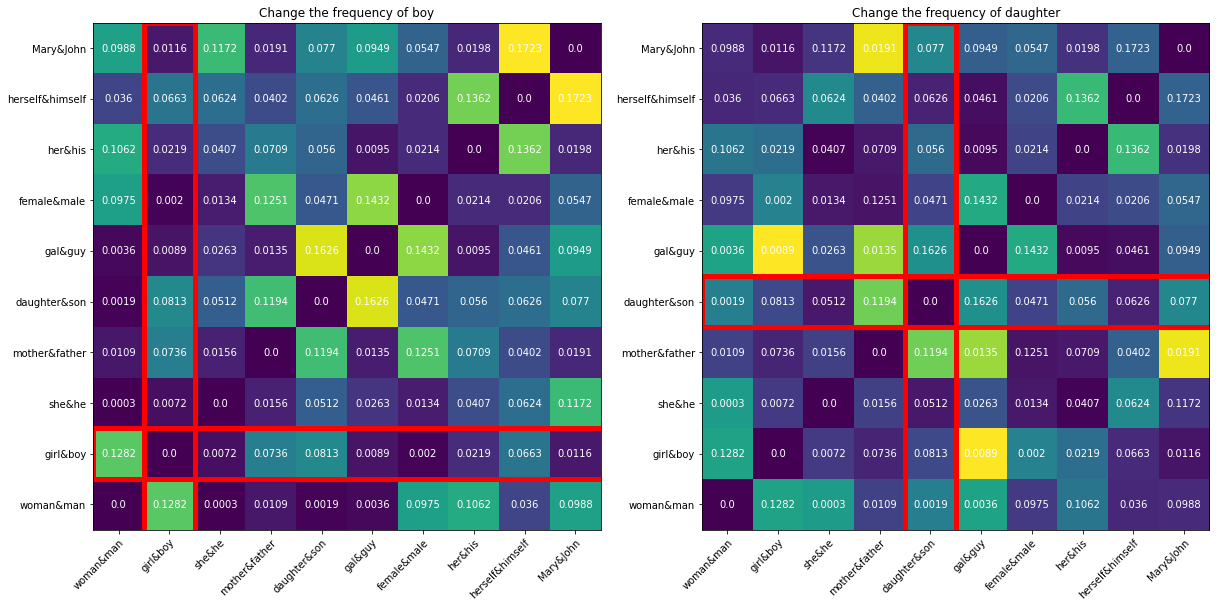

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, **dict(figsize=(20, 10)))
axes[0].imshow(np.flip(diff_cosine_b,axis=0))
axes[1].imshow(np.flip(diff_cosine_d,axis=0))

for ax in axes:
    ax.set_xticks(np.arange(len(utils.definitional_labels)))
    ax.set_yticks(np.arange(len(utils.definitional_labels)))
    ax.set_xticklabels(utils.definitional_labels)
    ax.grid(which="minor", color="r", linestyle='-', linewidth=10)
    ax.set_yticklabels(np.flip(utils.definitional_labels))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(len(utils.definitional_labels)):
    for j in range(len(utils.definitional_labels)):
        axes[0].text(j,i, np.round(np.flip(diff_cosine_b, axis=0)[i,j], decimals=4),ha="center", va="center", color="w")
        axes[1].text(j,i, np.round(np.flip(diff_cosine_b,axis=0)[i,j], decimals=4), ha="center", va="center", color="w")

# add outlines to highlight the augemented words
axes[0].add_patch(plt.Rectangle((0.5,-0.5), 1, 20,edgecolor="red", linewidth=5, fill=False))
axes[0].add_patch(plt.Rectangle((-0.5,7.5), 20, 1,edgecolor="red", linewidth=5, fill=False))
axes[1].add_patch(plt.Rectangle((3.5,-0.5), 1, 20,edgecolor="red", linewidth=5, fill=False))
axes[1].add_patch(plt.Rectangle((-0.5,4.5), 20, 1,edgecolor="red", linewidth=5, fill=False))

axes[0].set_title("Change the frequency of boy")
axes[1].set_title("Change the frequency of daughter")
plt.show()